In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.init as init
import numpy as np
from tqdm import tqdm

from model.CustomDataSet import CustomDataSetRNN
from model.Tokenizer import SimpleTokenizerV1
from environnement.environnement1Str import Environnement1
from environnement.environnement3Str import Environnement3
from environnement.environnement6Str import Environnement6
from environnement.small_loop import small_loop
from outil import *

In [2]:
# init data
env_test = small_loop(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1],
                [1, 0, 0, 0, 1],
                [1, 0, 1, 0, 1],
                [1, 0, 0, 0, 1],
                [1, 1, 1, 1, 1],
            ]))
actions, outcomes = [], []

for i in range(50):
    action = str(np.random.choice(env_test.get_actions()))
    outcome = env_test.outcome(action)
    actions.append(action)
    outcomes.append(outcome)

print(actions)
print(outcomes)

tokenizer = SimpleTokenizerV1(vocab=
        create_dico_numerate_word(env_test.get_outcomes() + env_test.get_actions()))

data_set = CustomDataSetRNN(actions=actions, outcomes=outcomes,
                    context_lenght=15, dim_out=2, tokenizer=tokenizer)

data_loader_train = DataLoader(data_set, batch_size=32, shuffle=True, num_workers=4, drop_last=True)

# text, target = next(iter(data_loader_train))
# print(text)
# print(target)


for i in range(1000):
    action = str(np.random.choice(env_test.get_actions()))
    outcome = env_test.outcome(action)
    actions.append(action)
    outcomes.append(outcome)

data_set_test = CustomDataSetRNN(actions=actions, outcomes=outcomes,
                    context_lenght=15, dim_out=2, tokenizer=tokenizer)

data_loader_test = DataLoader(data_set, batch_size=128, shuffle=True, num_workers=4, drop_last=True)

['forward', 'turn_right', 'turn_left', 'forward', 'feel_front', 'feel_front', 'feel_front', 'turn_right', 'feel_front', 'forward', 'turn_left', 'forward', 'turn_right', 'forward', 'turn_left', 'feel_front', 'turn_right', 'turn_right', 'turn_left', 'turn_left', 'turn_left', 'feel_front', 'turn_right', 'turn_left', 'forward', 'forward', 'feel_front', 'feel_front', 'feel_front', 'turn_left', 'turn_left', 'feel_front', 'turn_right', 'turn_right', 'forward', 'turn_right', 'turn_right', 'feel_front', 'feel_front', 'feel_front', 'turn_right', 'turn_right', 'turn_left', 'turn_right', 'turn_left', 'forward', 'turn_right', 'forward', 'forward', 'turn_left']
['wall', 'empty', 'empty', 'wall', 'wall', 'wall', 'wall', 'empty', 'empty', 'empty', 'empty', 'wall', 'empty', 'empty', 'empty', 'wall', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'wall', 'wall', 'wall', 'empty', 'empty', 'empty', 'empty', 'empty', 'wall', 'empty', 'empty', 'empty', 'empty', 'em

In [3]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)

print(input)
print(target)

tensor([[-0.9646, -0.1369, -0.0690,  0.3220,  0.0175],
        [-0.1445,  0.1132, -0.9277,  0.3051,  0.1117],
        [-1.7682, -1.0315,  0.6789, -1.3526,  1.5912]], requires_grad=True)
tensor([2, 1, 4])


Inspired by https://github.com/LukeDitria/pytorch_tutorials.git

In [4]:
class LSTM(nn.Module):
    def __init__(self, num_emb, output_size, num_layers=1, hidden_size=128, dropout=0.5):
        super(LSTM, self).__init__()
        
        # Create an embedding layer to convert token indices to dense vectors
        self.embedding = nn.Embedding(num_emb, hidden_size)
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True, dropout=dropout)
        
        # Define the output fully connected layer
        self.fc_out = nn.Linear(hidden_size, output_size)
        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        # Initialize embedding layer
        init.uniform_(self.embedding.weight, -0.1, 0.1)

        # Initialize LSTM weights
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                init.xavier_normal_(param)
            elif 'bias' in name:
                init.constant_(param, 0.0)

        # Initialize fully connected layer
        init.xavier_normal_(self.fc_out.weight)
        init.constant_(self.fc_out.bias, 0.0)

    def forward(self, input_seq, hidden_in, mem_in):
        # print device info
        # print(self.embedding.weight.device)
        # print(self.lstm.weight_hh_l0.device)
        # print(self.fc_out.weight.device)
        # print(self.fc_out.bias.device)
        # print(input_seq.device)
        # print(hidden_in.device)
        # print(mem_in.device)
        # print('---------------------')
        
        # Convert token indices to dense vectors
        input_embs = self.embedding(input_seq)

        # Pass the embeddings through the LSTM layer
        output, (hidden_out, mem_out) = self.lstm(input_embs, (hidden_in, mem_in))
                
        # Pass the LSTM output through the fully connected layer to get the final output
        return self.fc_out(output), hidden_out, mem_out

In [5]:
# Set the device to GPU if available, otherwise fallback to CPU
device = torch.device(0 if torch.cuda.is_available() else 'cpu')
device = "cpu"

# Define the size of the hidden layer and number of LSTM layers
hidden_size = 64
num_layers = 1
len_vocab = len(env_test.get_outcomes() + env_test.get_actions())

# Create the LSTM classifier model
lstm_classifier = LSTM(num_emb=len_vocab, output_size=2, 
                       num_layers=num_layers, hidden_size=hidden_size).to(device)

# Initialize the optimizer with Adam optimizer
optimizer = optim.AdamW(lstm_classifier.parameters(), lr=0.01)

# Define the loss function as CrossEntropyLoss for classification
loss_fn = nn.CrossEntropyLoss()

# Initialize lists to store training and test loss, as well as accuracy
training_loss_logger = []
test_loss_logger = []
training_acc_logger = []
test_acc_logger = []

/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


In [6]:
# Initialize training and test accuracy
train_acc = 0
test_acc = 0

# Loop through each epoch
for epoch in range(100):    
    # Set model to training mode
    lstm_classifier.train()
    steps = 0
    train_acc = 0
    test_acc = 0
    
    # Iterate through training data loader
    for text, label in data_loader_train:
        text = text.to(device)
        label = label.to(device)
        
        bs = label.shape[0]

        # Initialize hidden and memory states
        hidden = torch.zeros(num_layers, bs, hidden_size, device=device)
        memory = torch.zeros(num_layers, bs, hidden_size, device=device)
        
        # Forward pass through the model
        pred, hidden, memory = lstm_classifier(text, hidden, memory)

        # Calculate the loss
        loss = loss_fn(pred[:, -1, :], label)
            
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Append training loss to logger
        training_loss_logger.append(loss.item())
        
        # Calculate training accuracy
        train_acc += (pred[:, -1, :].argmax(1) == label).sum()
        steps += bs
        # print(f"acc : {train_acc/steps} / {train_acc} / {steps} for epoch {epoch}")
        
    # Calculate and append training accuracy for the epoch
    print(f"acc : {train_acc/steps} / {train_acc} / {steps} for epoch {epoch}")
    train_acc = train_acc / steps
    training_acc_logger.append(train_acc)
    
    # Set model to evaluation mode
    lstm_classifier.eval()
    steps = 0
    
    # Iterate through test data loader
    with torch.no_grad():
        for text, label in data_loader_test:
            text = text.to(device)
            label = label.to(device)
            bs = label.shape[0]

            # Initialize hidden and memory states
            hidden = torch.zeros(num_layers, bs, hidden_size, device=device)
            memory = torch.zeros(num_layers, bs, hidden_size, device=device)
            
            # Forward pass through the model
            pred, hidden, memory = lstm_classifier(text, hidden, memory)

            # Calculate the loss
            loss = loss_fn(pred[:, -1, :], label)
            test_loss_logger.append(loss.item())

            # Calculate test accuracy
            test_acc += (pred[:, -1, :].argmax(1) == label).sum()
            steps += bs

        # Calculate and append test accuracy for the epoch
        test_acc = (test_acc/steps).item()
        test_acc_logger.append(test_acc)
    print(f"acc de la val : {test_acc} for epoch {epoch}")

acc : 0.828125 / 848 / 1024 for epoch 0
acc de la val : 0.8916015625 for epoch 0
acc : 0.8984375 / 920 / 1024 for epoch 1
acc de la val : 0.9091796875 for epoch 1
acc : 0.9091796875 / 931 / 1024 for epoch 2
acc de la val : 0.9072265625 for epoch 2
acc : 0.9013671875 / 923 / 1024 for epoch 3
acc de la val : 0.912109375 for epoch 3
acc : 0.9150390625 / 937 / 1024 for epoch 4
acc de la val : 0.921875 for epoch 4
acc : 0.9140625 / 936 / 1024 for epoch 5
acc de la val : 0.9248046875 for epoch 5
acc : 0.9169921875 / 939 / 1024 for epoch 6
acc de la val : 0.9150390625 for epoch 6
acc : 0.9150390625 / 937 / 1024 for epoch 7
acc de la val : 0.931640625 for epoch 7
acc : 0.9287109375 / 951 / 1024 for epoch 8
acc de la val : 0.9326171875 for epoch 8
acc : 0.935546875 / 958 / 1024 for epoch 9
acc de la val : 0.9375 for epoch 9
acc : 0.93359375 / 956 / 1024 for epoch 10
acc de la val : 0.9404296875 for epoch 10
acc : 0.9267578125 / 949 / 1024 for epoch 11
acc de la val : 0.9443359375 for epoch 11
a

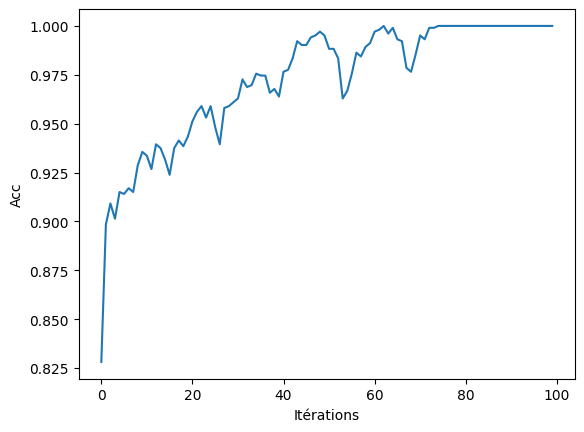

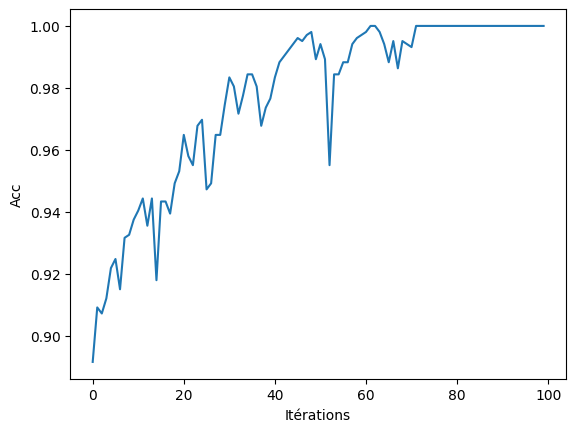

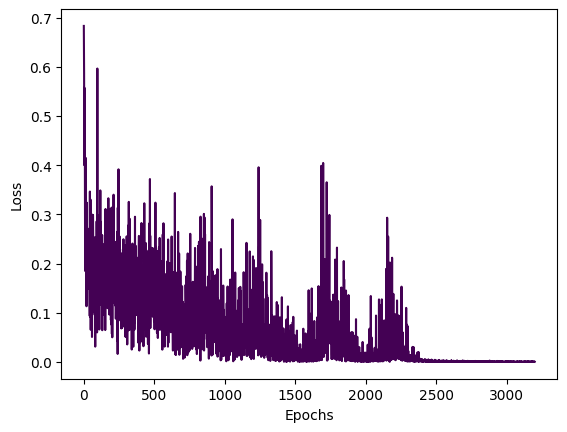

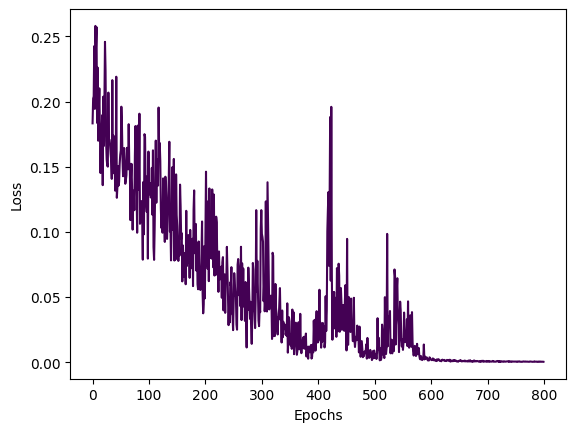

In [7]:
see_evolued_acc(training_acc_logger)
see_evolued_acc(test_acc_logger)

see_evolued_loss([training_loss_logger])
see_evolued_loss([test_loss_logger])

In [8]:
print(training_loss_logger)

[0.6833415627479553, 0.6399286985397339, 0.586027979850769, 0.4002741575241089, 0.557746946811676, 0.450206458568573, 0.48105278611183167, 0.46352988481521606, 0.32241812348365784, 0.23849043250083923, 0.38072288036346436, 0.18462824821472168, 0.319489985704422, 0.2208559811115265, 0.2029704451560974, 0.4146009087562561, 0.15873609483242035, 0.20188862085342407, 0.18315358459949493, 0.11322937160730362, 0.2615397274494171, 0.323856383562088, 0.2923177182674408, 0.25239601731300354, 0.2583717107772827, 0.24267621338367462, 0.2714942991733551, 0.16579028964042664, 0.26456454396247864, 0.1652756631374359, 0.24928879737854004, 0.2629949450492859, 0.2127113938331604, 0.23221036791801453, 0.22274406254291534, 0.16885747015476227, 0.14917707443237305, 0.20116807520389557, 0.1618921309709549, 0.1728961318731308, 0.2454456388950348, 0.13673807680606842, 0.09362481534481049, 0.34647610783576965, 0.09211770445108414, 0.12977056205272675, 0.29448676109313965, 0.330410361289978, 0.27454331517219543

In [9]:
list_acc_train = []
list_acc_test = []
list_loss_train = []
list_loss_test = []

for i in tqdm(range(50)):
    hidden_size = 64
    num_layers = 1
    len_vocab = len(env_test.get_outcomes() + env_test.get_actions())

    # Create the LSTM classifier model
    lstm_classifier = LSTM(num_emb=len_vocab, output_size=2, 
                        num_layers=num_layers, hidden_size=hidden_size).to(device)

    # Initialize the optimizer with Adam optimizer
    optimizer = optim.AdamW(lstm_classifier.parameters(), lr=0.01)

    # Define the loss function as CrossEntropyLoss for classification
    loss_fn = nn.CrossEntropyLoss()

    # Initialize lists to store training and test loss, as well as accuracy
    training_loss_logger = []
    test_loss_logger = []
    training_acc_logger = []
    test_acc_logger = []
        
    # Initialize training and test accuracy
    train_acc = 0
    test_acc = 0

    # Loop through each epoch
    for epoch in range(100):    
        # Set model to training mode
        lstm_classifier.train()
        steps = 0
        train_acc = 0
        test_acc = 0
        
        # Iterate through training data loader
        for text, label in data_loader_train:
            bs = label.shape[0]
            

            # Initialize hidden and memory states
            hidden = torch.zeros(num_layers, bs, hidden_size, device=device)
            memory = torch.zeros(num_layers, bs, hidden_size, device=device)
            
            # Forward pass through the model
            pred, hidden, memory = lstm_classifier(text, hidden, memory)

            # Calculate the loss
            loss = loss_fn(pred[:, -1, :], label)
                
            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Calculate training accuracy
            train_acc += (pred[:, -1, :].argmax(1) == label).sum()
            steps += bs
            # print(f"acc : {train_acc/steps} / {train_acc} / {steps} for epoch {epoch}")
            
        # Calculate and append training accuracy for the epoch
        # print(f"acc : {train_acc/steps} / {train_acc} / {steps} for epoch {epoch}")
        # Append last training loss to logger
        training_loss_logger.append(loss.item())
        train_acc = train_acc / steps
        training_acc_logger.append(train_acc)
        
        # Set model to evaluation mode
        lstm_classifier.eval()
        steps = 0
        
        # Iterate through test data loader
        with torch.no_grad():
            for text, label in data_loader_test:
                bs = label.shape[0]

                # Initialize hidden and memory states
                hidden = torch.zeros(num_layers, bs, hidden_size, device=device)
                memory = torch.zeros(num_layers, bs, hidden_size, device=device)
                
                # Forward pass through the model
                pred, hidden, memory = lstm_classifier(text, hidden, memory)

                # Calculate test accuracy
                test_acc += (pred[:, -1, :].argmax(1) == label).sum()
                steps += bs
            
            # Calculate the loss
            loss = loss_fn(pred[:, -1, :], label)
            test_loss_logger.append(loss.item())

            # Calculate and append test accuracy for the epoch
            test_acc = (test_acc/steps).item()
            test_acc_logger.append(test_acc)
        # print(f"acc de la val : {test_acc} for epoch {epoch}")
        
    list_acc_train.append(training_acc_logger)
    list_acc_test.append(test_acc_logger)
    list_loss_train.append(training_loss_logger)
    list_loss_test.append(test_loss_logger)


  0%|          | 0/50 [00:00<?, ?it/s]/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
100%|██████████| 50/50 [18:17<00:00, 21.96s/it]


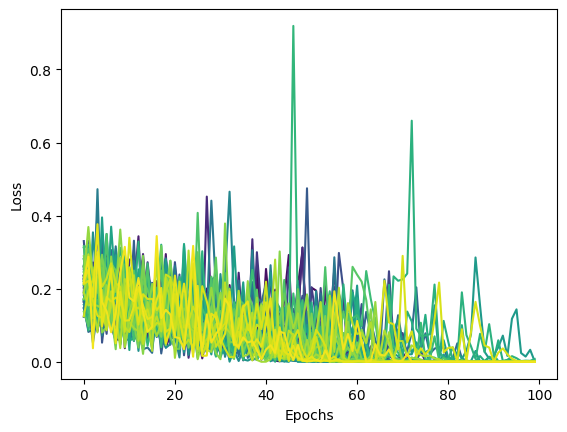

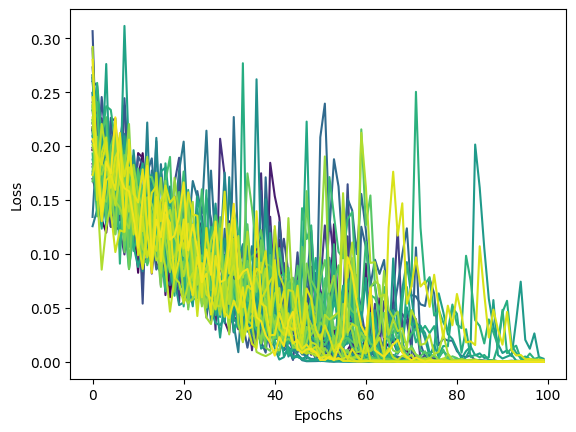

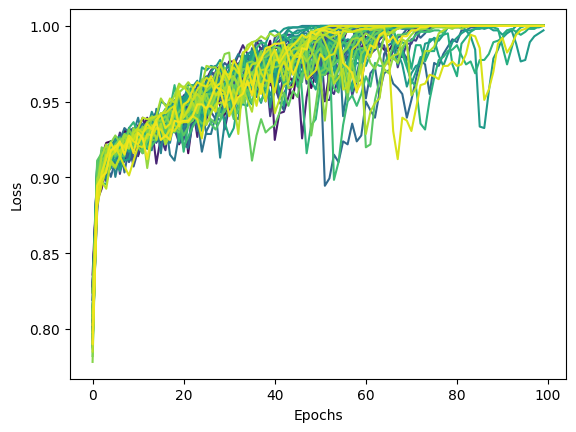

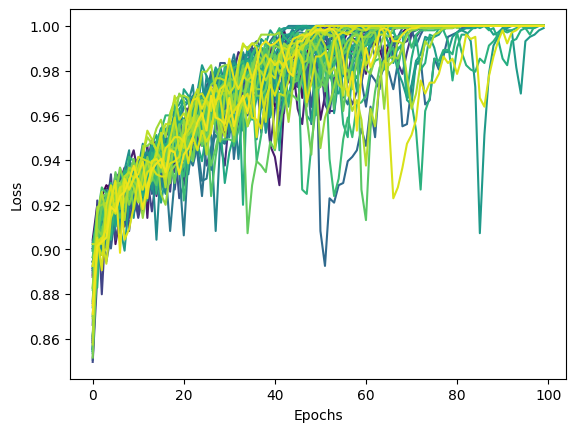

49
49


In [10]:
see_evolued_loss(list_loss_train)
see_evolued_loss(list_loss_test)
see_evolued_loss(list_acc_train)
see_evolued_loss(list_acc_test)
# Count nb acc at 1 for last epoch
print(len([i for i in list_acc_test if i[-1] == 1]))
print(len([i for i in list_acc_train if i[-1] == 1]))

In [11]:
list_acc_train = []
list_acc_test = []
list_loss_train = []
list_loss_test = []

for i in tqdm(range(50)):
    actions, outcomes = [], []
    for i in range(100):
        action = str(np.random.choice(env_test.get_actions()))
        outcome = env_test.outcome(action)
        actions.append(action)
        outcomes.append(outcome)
        
    data_set = CustomDataSetRNN(actions=actions, outcomes=outcomes,
                    context_lenght=15, dim_out=2, tokenizer=tokenizer)

    data_loader_train = DataLoader(data_set, batch_size=32, shuffle=True, num_workers=4, drop_last=True)
        
    hidden_size = 64
    num_layers = 4
    len_vocab = len(env_test.get_outcomes() + env_test.get_actions())

    # Create the LSTM classifier model
    lstm_classifier = LSTM(num_emb=len_vocab, output_size=2, 
                        num_layers=num_layers, hidden_size=hidden_size, dropout=0.2).to(device)

    # Initialize the optimizer with Adam optimizer
    optimizer = optim.AdamW(lstm_classifier.parameters(), lr=0.01)

    # Define the loss function as CrossEntropyLoss for classification
    loss_fn = nn.CrossEntropyLoss()

    # Initialize lists to store training and test loss, as well as accuracy
    training_loss_logger = []
    test_loss_logger = []
    training_acc_logger = []
    test_acc_logger = []
        
    # Initialize training and test accuracy
    train_acc = 0
    test_acc = 0

    # Loop through each epoch
    for epoch in range(100):    
        # Set model to training mode
        lstm_classifier.train()
        steps = 0
        train_acc = 0
        test_acc = 0
        
        # Iterate through training data loader
        for text, label in data_loader_train:
            bs = label.shape[0]
            

            # Initialize hidden and memory states
            hidden = torch.zeros(num_layers, bs, hidden_size, device=device)
            memory = torch.zeros(num_layers, bs, hidden_size, device=device)
            
            # Forward pass through the model
            pred, hidden, memory = lstm_classifier(text, hidden, memory)

            # Calculate the loss
            loss = loss_fn(pred[:, -1, :], label)
                
            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Calculate training accuracy
            train_acc += (pred[:, -1, :].argmax(1) == label).sum()
            steps += bs
            # print(f"acc : {train_acc/steps} / {train_acc} / {steps} for epoch {epoch}")
            
        # Calculate and append training accuracy for the epoch
        # print(f"acc : {train_acc/steps} / {train_acc} / {steps} for epoch {epoch}")
        # Append last training loss to logger
        training_loss_logger.append(loss.item())
        train_acc = train_acc / steps
        training_acc_logger.append(train_acc)
        
        # Set model to evaluation mode
        lstm_classifier.eval()
        steps = 0
        
        # Iterate through test data loader
        with torch.no_grad():
            for text, label in data_loader_test:
                bs = label.shape[0]

                # Initialize hidden and memory states
                hidden = torch.zeros(num_layers, bs, hidden_size, device=device)
                memory = torch.zeros(num_layers, bs, hidden_size, device=device)
                
                # Forward pass through the model
                pred, hidden, memory = lstm_classifier(text, hidden, memory)

                # Calculate test accuracy
                test_acc += (pred[:, -1, :].argmax(1) == label).sum()
                steps += bs
            
            # Calculate the loss
            loss = loss_fn(pred[:, -1, :], label)
            test_loss_logger.append(loss.item())

            # Calculate and append test accuracy for the epoch
            test_acc = (test_acc/steps).item()
            test_acc_logger.append(test_acc)
        # print(f"acc de la val : {test_acc} for epoch {epoch}")
        
    list_acc_train.append(training_acc_logger)
    list_acc_test.append(test_acc_logger)
    list_loss_train.append(training_loss_logger)
    list_loss_test.append(test_loss_logger)


100%|██████████| 50/50 [12:03<00:00, 14.47s/it]


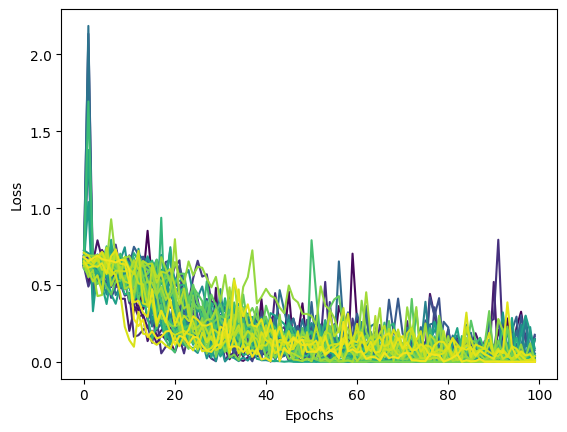

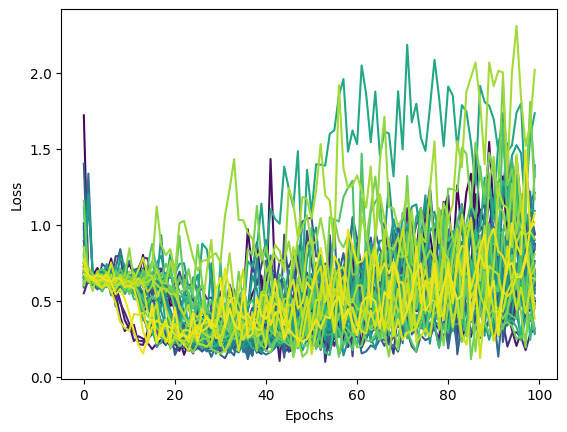

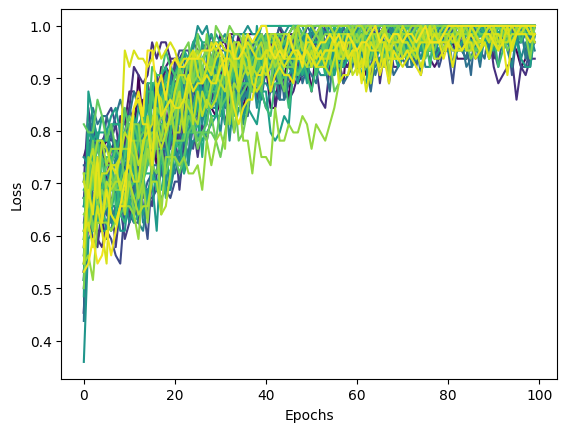

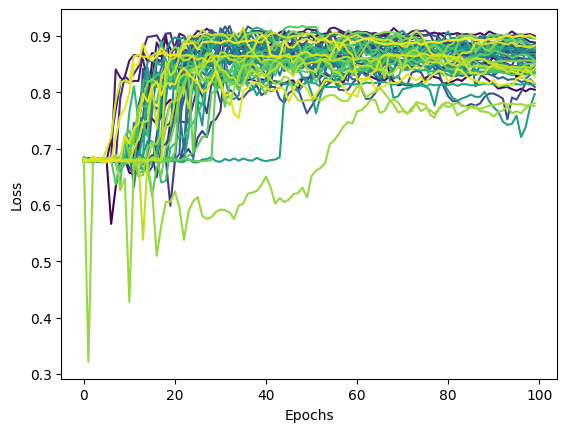

In [12]:
see_evolued_loss(list_loss_train)
see_evolued_loss(list_loss_test)
see_evolued_loss(list_acc_train)
see_evolued_loss(list_acc_test)